In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import kagglehub
import os
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Download latest version
path = kagglehub.dataset_download("kundanbedmutha/exam-score-prediction-dataset")

print("Path to dataset files:", path)
csv_files = [f for f in os.listdir(path) if f.endswith('.csv')]
df = pd.read_csv(os.path.join(path, csv_files[0]))

100%|██████████| 318k/318k [00:00<00:00, 14.5MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/kundanbedmutha/exam-score-prediction-dataset/versions/2


In [2]:
# Add a classification column
df['status'] = pd.cut(df['exam_score'],
                      bins=[-float('inf'), 59, float('inf')],
                      labels=[0, 1]).astype(int)

In [3]:
def metrics_calc(pred, y_test):
  # Convert probabilities to 0 or 1
  y_pred = (pred >= 0.5).astype(int)

  # Calculate outcomes
  tp = np.sum((y_pred == 1) & (y_test == 1)) # True Positives
  tn = np.sum((y_pred == 0) & (y_test == 0)) # True Negatives
  fp = np.sum((y_pred == 1) & (y_test == 0)) # False Positives
  fn = np.sum((y_pred == 0) & (y_test == 1)) # False Negatives

  precision = tp / (tp + fp) if (tp + fp) > 0 else 0
  recall = tp / (tp + fn) if (tp + fn) > 0 else 0
  f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

  # print(f"Precision: {precision:.2f}")
  # print(f"Recall:    {recall:.2f}")
  # print(f"F1 Score:  {f1:.2f}")

  return precision, recall, f1

In [4]:
# perform label encoding for internet_access column
df.internet_access = df.internet_access.map({ 'no': 0, 'yes': 1})

# one hot encoding of Embarked and Title columns
for column in ['gender', 'course', 'sleep_quality', 'study_method', 'facility_rating', 'exam_difficulty']:
    dummies = pd.get_dummies(df[column], prefix=column, drop_first=True)
    df = pd.concat([df, dummies], axis=1).drop([column], axis=1)

In [5]:
# Split the data
X = df.drop(columns=['student_id', 'exam_score', 'status'])
y = df['status']

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = np.asarray(X_train, dtype=np.float64)
y_train = np.asarray(y_train, dtype=np.float64)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(16000, 23) (4000, 23)
(16000,) (4000,)


In [6]:
scaler = StandardScaler()
# Fit only on training data to avoid leaking info from the test set
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


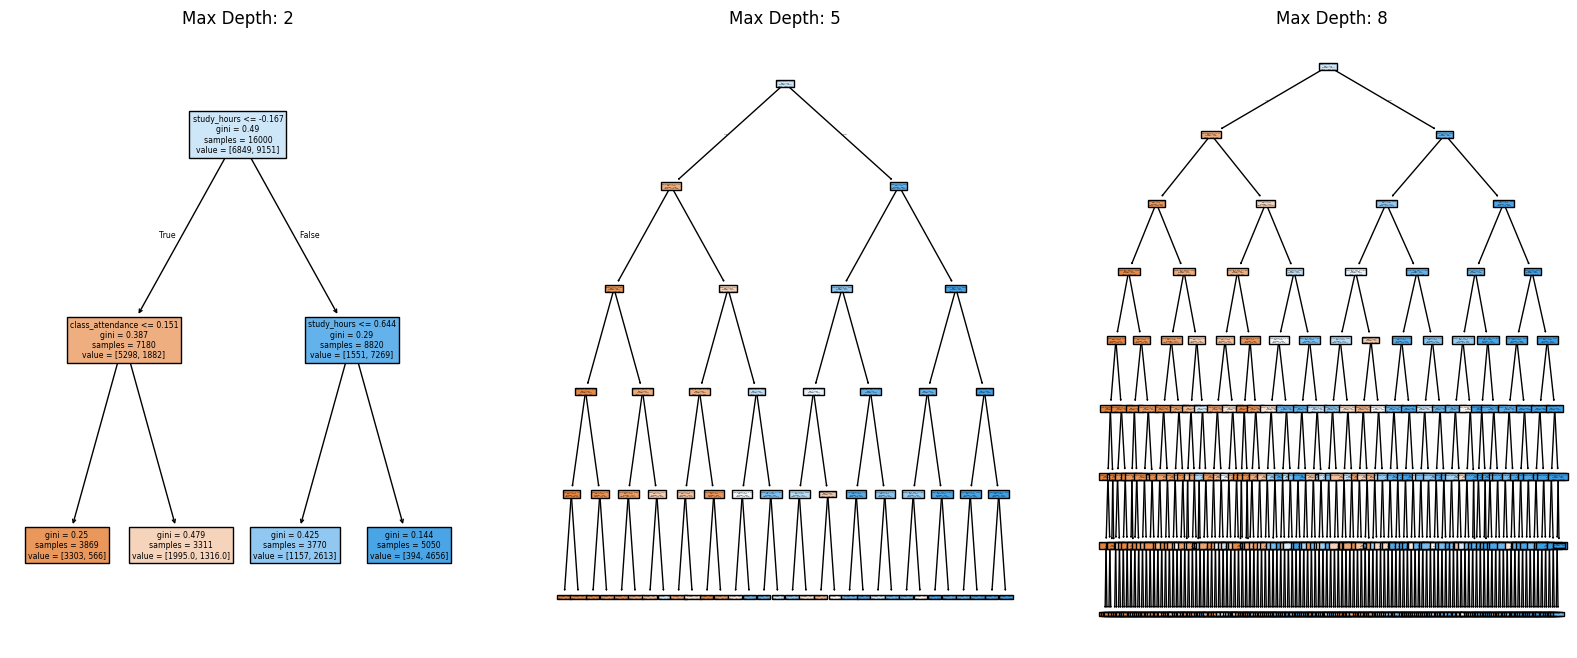

In [7]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# Test three different depths
depths = [2, 5, 8]
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

for i, d in enumerate(depths):
    # Initialize and fit
    dt = DecisionTreeClassifier(max_depth=d, random_state=42)
    dt.fit(X_train, y_train)

    # Visualize the structure
    plot_tree(dt, max_depth=8, feature_names=X.columns, filled=True, ax=axes[i])
    axes[i].set_title(f"Max Depth: {d}")

plt.show()

# Depth and Complexity

Depth 2:
- At this depth the tree makes broad generalizations based on only 1 or 2 features. It is easy to interpret but may suffer from underfitting.

Depth 5:
- At this depth the tree can pick up on interactions between features and is considering more features is general.

Depth 15:
- The tree becomes very big and start to create leaf nodes for small groups of students. Its likely that with this many leaf nodes the tree is overfitting and won't be able to predict well outside of the training data.






# Sensitivity Analysis
How different variables influence the outcome of a dependent variable. This can be tested by seeing the results after varying specific variables while leaving the other constant. We can quantify how much a specific variable "drives" the model's decision boundary or prediction probability.


https://www.investopedia.com/terms/s/sensitivityanalysis.asp

Index 0: age
Index 1: study_hours
Index 2: class_attendance
Index 3: internet_access
Index 4: sleep_hours
Index 5: gender_male
Index 6: gender_other
Index 7: course_b.sc
Index 8: course_b.tech
Index 9: course_ba
Index 10: course_bba
Index 11: course_bca
Index 12: course_diploma
Index 13: sleep_quality_good
Index 14: sleep_quality_poor
Index 15: study_method_group study
Index 16: study_method_mixed
Index 17: study_method_online videos
Index 18: study_method_self-study
Index 19: facility_rating_low
Index 20: facility_rating_medium
Index 21: exam_difficulty_hard
Index 22: exam_difficulty_moderate


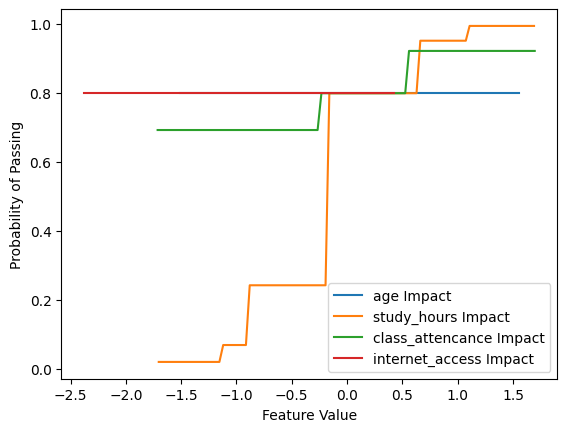

In [8]:
def perform_sensitivity(model, feature_index, X_base):
    # Take a "median" student as our baseline
    base_student = np.median(X_base, axis=0).reshape(1, -1)

    # Sweep the feature from its minimum to maximum value
    feature_range = np.linspace(X_base[:, feature_index].min(),
                                X_base[:, feature_index].max(), 100)

    sensitivities = []
    for val in feature_range:
        temp_student = base_student.copy()
        temp_student[0, feature_index] = val
        # Get probability of "Passing" (class 1)
        prob = model.predict_proba(temp_student)[0, 1]
        sensitivities.append(prob)

    return feature_range, sensitivities

for i, name in enumerate(X.columns):
  print(f"Index {i}: {name}")

dt = DecisionTreeClassifier(max_depth=5, random_state=42)
dt.fit(X_train, y_train)

# Analyze features
feat_1_range, feat_1_probs = perform_sensitivity(dt, 0, X_train) # Feature 0
feat_2_range, feat_2_probs = perform_sensitivity(dt, 1, X_train) # Feature 1
feat_3_range, feat_3_probs = perform_sensitivity(dt, 2, X_train) # Feature 2
feat_4_range, feat_4_probs = perform_sensitivity(dt, 3, X_train) # Feature 3

# Plot the results
plt.plot(feat_1_range, feat_1_probs, label="age Impact")
plt.plot(feat_2_range, feat_2_probs, label="study_hours Impact")
plt.plot(feat_3_range, feat_3_probs, label="class_attencance Impact")
plt.plot(feat_4_range, feat_4_probs, label="internet_access Impact")
plt.xlabel("Feature Value")
plt.ylabel("Probability of Passing")
plt.legend()
plt.show()

In [9]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_predict

# Initialize the Models
models = {
    "Bagging (Random Forest)": RandomForestClassifier(n_estimators=100, random_state=42),
    "Boosting (Gradient Boosting)": GradientBoostingClassifier(n_estimators=100, random_state=42)
}

# 3. Define the Fold counts to test
fold_counts = [5, 10, 15]
results_data = []

for k in fold_counts:
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

    for name, model in models.items():
        # Perform Cross-Validation
        y_pred_cv = cross_val_predict(model, X_train, y_train, cv=skf)

        # Call your custom function
        p, r, f = metrics_calc(y_train, y_pred_cv)

        results_data.append({
            "K-Folds": k,
            "Algorithm": name,
            "Precision": round(p, 2),
            "Recall": round(r, 2),
            "F1": round(f, 2)
        })

# Display as a clean Table
final_report = pd.DataFrame(results_data)
print(final_report)

   K-Folds                     Algorithm  Precision  Recall    F1
0        5       Bagging (Random Forest)       0.86    0.85  0.85
1        5  Boosting (Gradient Boosting)       0.87    0.86  0.86
2       10       Bagging (Random Forest)       0.86    0.85  0.86
3       10  Boosting (Gradient Boosting)       0.87    0.86  0.86
4       15       Bagging (Random Forest)       0.86    0.85  0.86
5       15  Boosting (Gradient Boosting)       0.87    0.86  0.86


# Stratified k-Fold Cross-Validation


Stratified k-fold cross-validation is a method of validating the results of your trainined models by splitting the data into k stratistifed (of an equal distribution of the target label in the full dataset) datasets of the same size. The model is trained $k$ times. In each iteration, it trains on $k-1$ folds and is tested on the remaining fold. Averaging these results provides a reliable estimate of model accuracy and stability through different data perturbations.


---
Source:
Kohavi, R. (1995). "A Study of Cross-Validation and Bootstrap for Accuracy Estimation and Model Selection." Published in the Proceedings of the 14th International Joint Conference on Artificial Intelligence (IJCAI).


# Algorithm Behavior under different Metrics.

The performance ranking of the algorithms can change based on the metric used. If you only looked at the F1 scores, you would assume that the Bagging and Boosting methods are almost the same and can be used interchangeably. By looking at all the other metrics, its clear that the Boosting algorithm outperforms the bagging algorithm on this dataset.

---

Bagging (Random Forest):
- Behavior: It averages the results of many independent trees. This approach relies on multiple classifiers agreeing on the prediction.

- Metric Impact: It tends to produce very stable Precision. It won't make wild predictions, but because it is conservative, its Recall might be lower (it might miss some passing students because the majority of trees weren't 100% sure).

Boosting (Gradient Boosting):
- Bahavior: Each new tree focuses specifically on the students the previous tree got wrong. This approach is more aggressive.

- Metric Impact: It usually achieves higher Recall. It is very good at hunting down difficult cases, but this aggression can sometimes lead to more False Positives, which can cause Precision to dip slightly compared to Bagging.

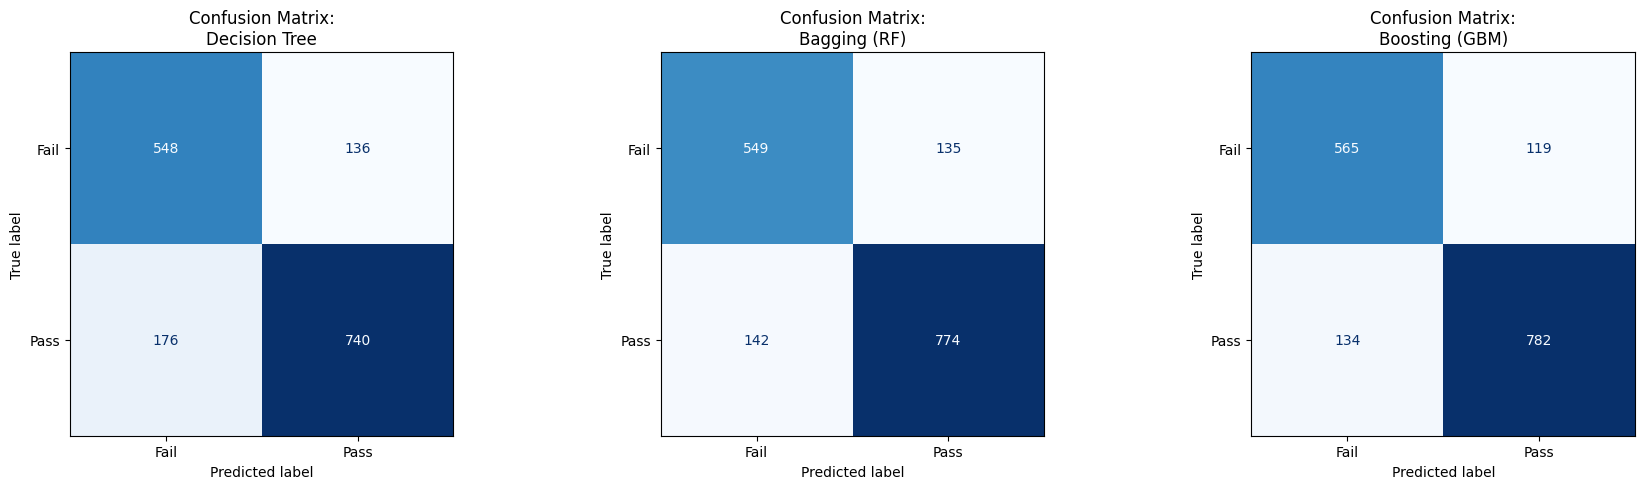

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 1. Define your three models
comparison_models = {
    "Decision Tree": dt,
    "Bagging (RF)": RandomForestClassifier(n_estimators=100, random_state=42),
    "Boosting (GBM)": GradientBoostingClassifier(n_estimators=100, random_state=42)
}

# 2. Grab a consistent test fold (Fold 1)
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
train_idx, test_idx = next(skf.split(X_train, y_train))
X_f_train, X_f_test = X_train[train_idx], X_train[test_idx]
y_f_train, y_f_test = y_train[train_idx], y_train[test_idx]

# 3. Plot them side-by-side
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, (name, model) in enumerate(comparison_models.items()):
    model.fit(X_f_train, y_f_train)
    y_pred = model.predict(X_f_test)

    cm = confusion_matrix(y_f_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fail', 'Pass'])
    disp.plot(ax=axes[i], cmap='Blues', colorbar=False)
    axes[i].set_title(f"Confusion Matrix:\n{name}")

plt.tight_layout()
plt.show()

In [17]:
from scipy import stats
from sklearn.model_selection import cross_val_score

# Get 10-fold scores for each
dt_scores = cross_val_score(comparison_models["Decision Tree"], X_train, y_train, cv=skf)
bag_scores = cross_val_score(comparison_models["Bagging (RF)"], X_train, y_train, cv=skf)
boost_scores = cross_val_score(comparison_models["Boosting (GBM)"], X_train, y_train, cv=skf)

# Perform tests
t_bag, p_bag = stats.ttest_rel(dt_scores, bag_scores)
t_boost, p_boost = stats.ttest_rel(dt_scores, boost_scores)

print(f"DT vs Bagging P-value:  {p_bag:.5f}")
print(f"DT vs Boosting P-value: {p_boost:.5f}")

DT vs Bagging P-value:  0.00000
DT vs Boosting P-value: 0.00000


**Brief Interpretation:** There is a 0% probability that the performance jump from the Decision Tree to the Ensembles happened by "random luck."

**Ensembles Win**: Both Bagging and Boosting are mathematically superior for this student dataset.

**Bias-Variance**: The single Decision Tree was too unstable (High Variance). The Ensembles successfully stabilized the predictions and captured complex patterns the single tree missed.

# Bias and Variance Trade-off

**Standard Decision Tree**:
This model has a tendency to overfit when given too many layers since the data will split continually until the leaf nodes contain small portions of the data. This model is prone to resulting in low bias but high variance.

**Bagging (Random Forest)**:
This technique smooths out noise by averaging many trees, resulting in a more stable result. The model will have low variance but moderate bias.


**Boosting (Gradient Boosting)**:
This technique starts with weak trees (high bias) and improves them sequentially. The model can overfit if not properly tuned but otherwise, it acheives low bias and low variance.

